## Column Cropping

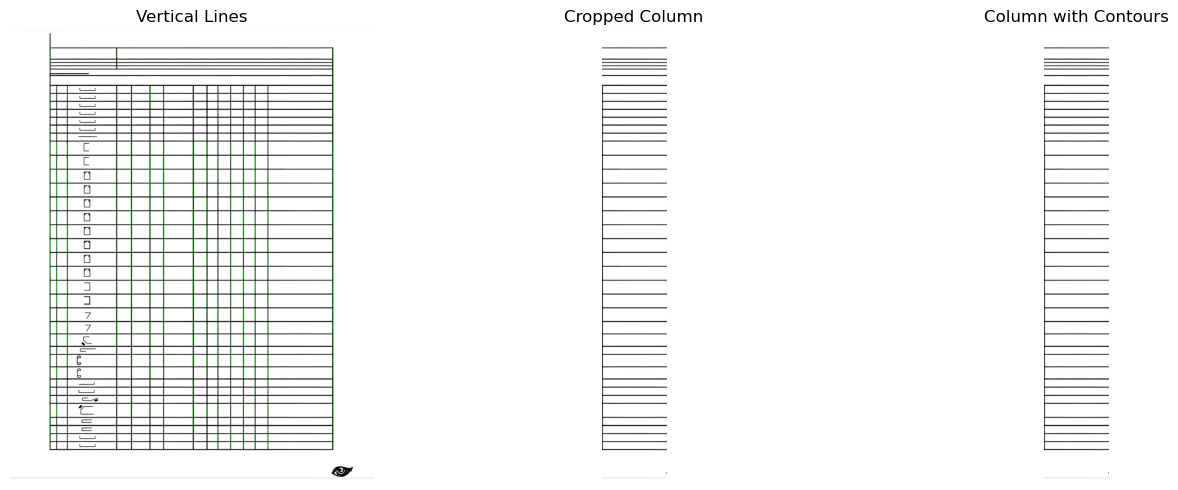

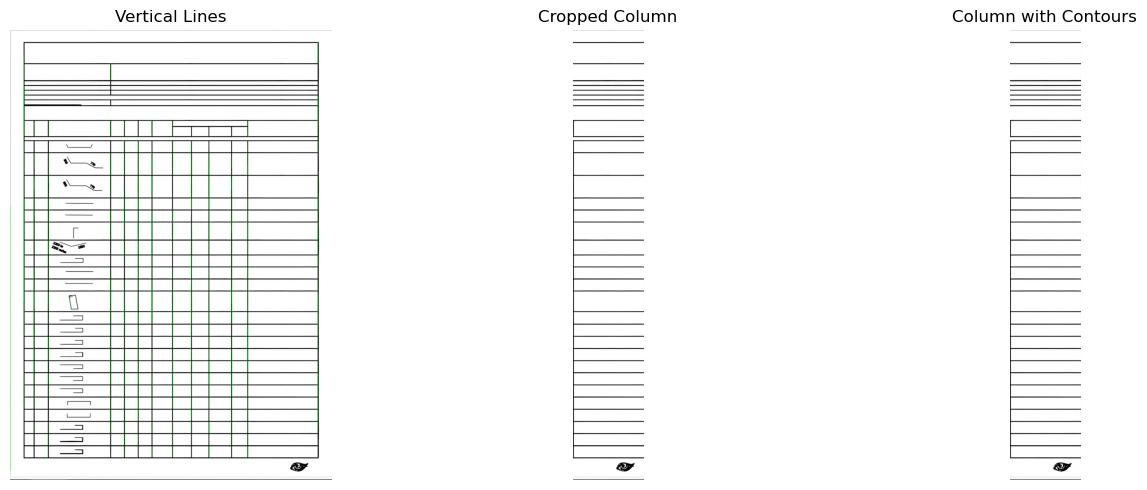

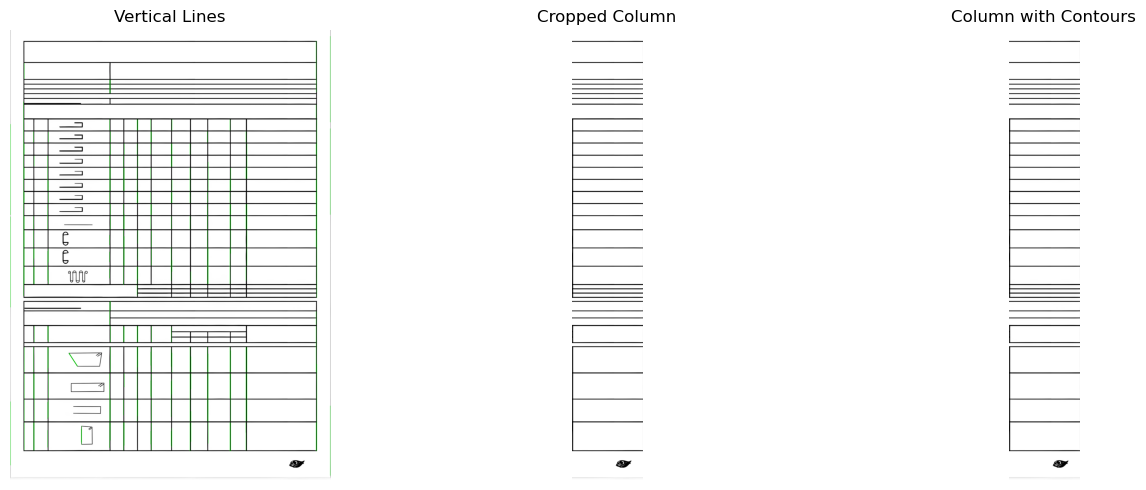

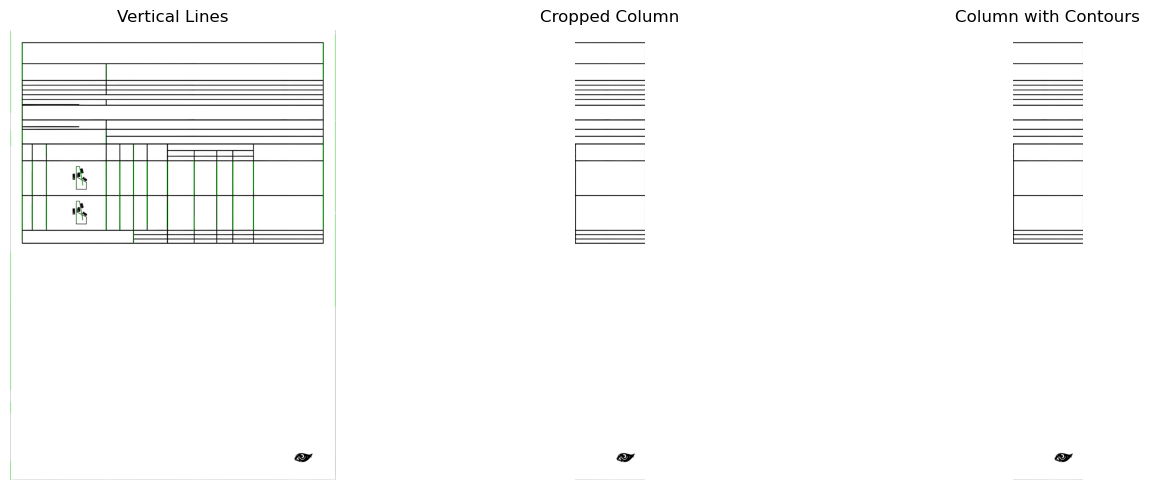

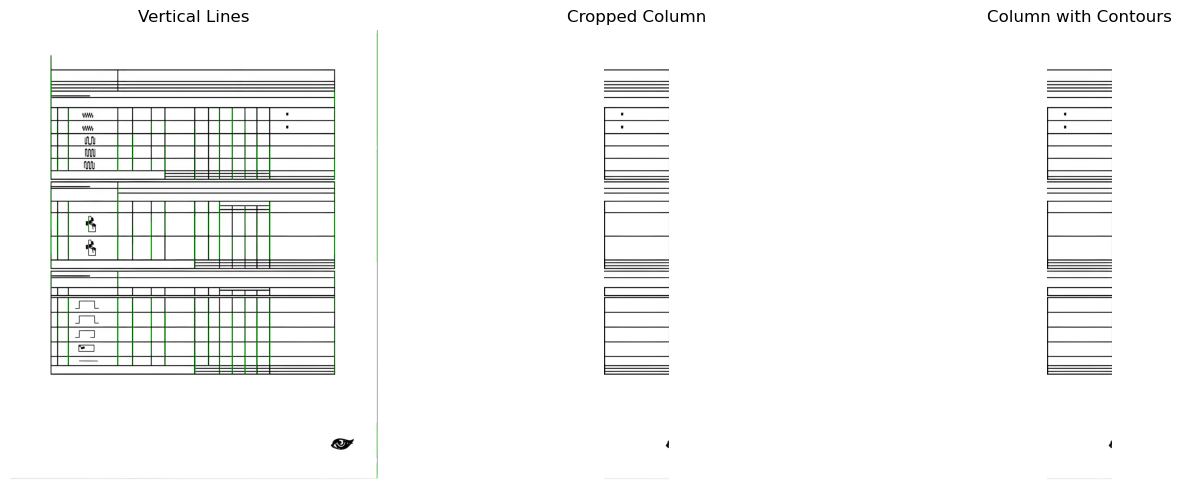

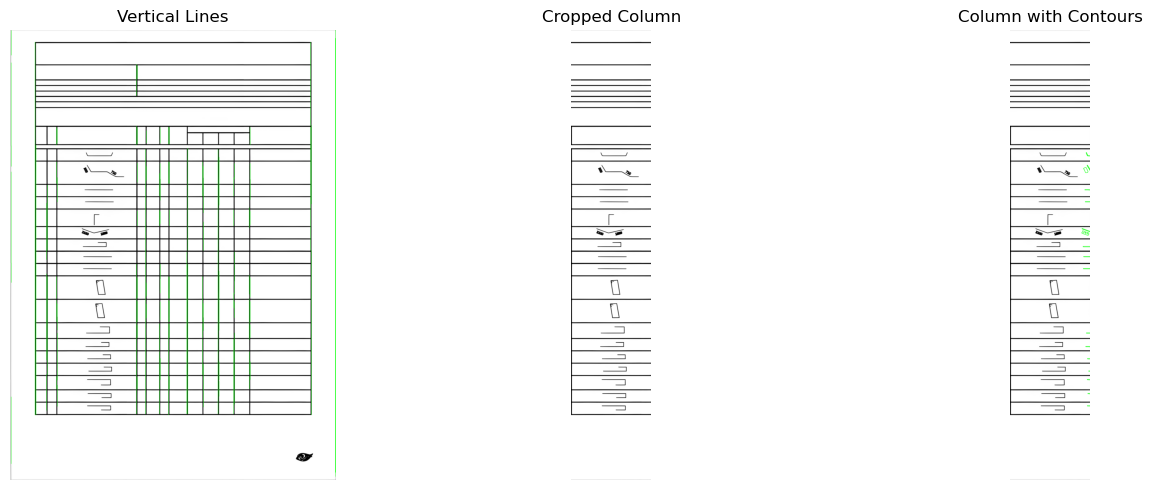

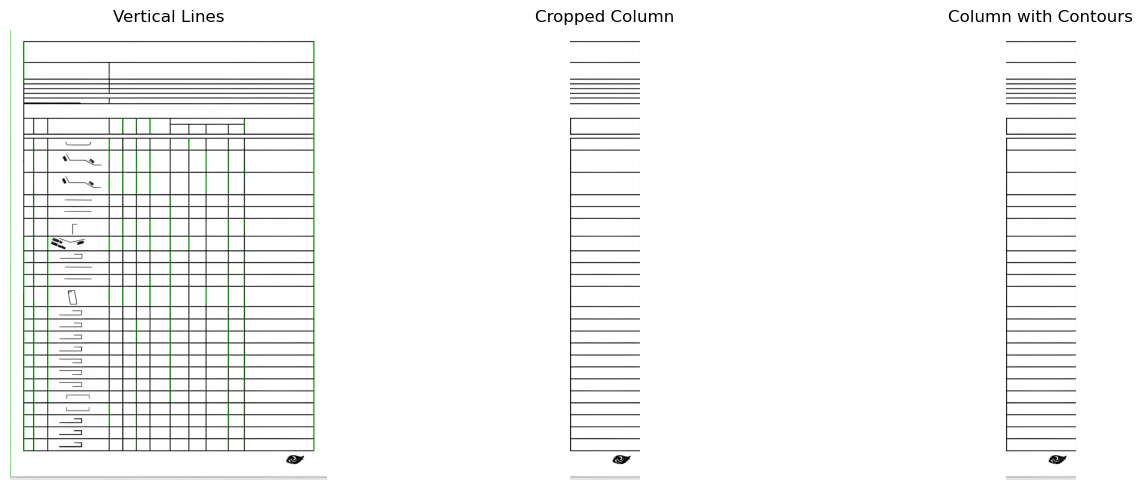

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define input and output directories
input_dir = "Pages"
output_dir = "CC"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Function to process each image
def process_image(img_path):
    # Read the image using OpenCV
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Apply Gaussian blur to reduce noise
    blurred_img = cv2.GaussianBlur(img, (5, 5), 0)

    # Apply Canny edge detection
    edges = cv2.Canny(blurred_img, 50, 150, apertureSize=3)

    # Find contours using hierarchical contouring
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Detect lines using probabilistic Hough transform
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=100, minLineLength=100, maxLineGap=10)

    # Draw lines on a copy of the original image
    lines_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    vertical_lines = []
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if abs(x1 - x2) < abs(y1 - y2):
                cv2.line(lines_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                vertical_lines.append(int((x1 + x2) / 2))

    # Set minimum distance between vertical lines
    min_distance = 20  # Adjust this value as per your requirement

    # Sort vertical line x-coordinates
    vertical_lines.sort()

    # Filter out consecutive lines that are too close
    filtered_vertical_lines = [vertical_lines[0]]
    for i in range(1, len(vertical_lines)):
        if vertical_lines[i] - filtered_vertical_lines[-1] > min_distance:
            filtered_vertical_lines.append(vertical_lines[i])

    # Variable to store the column with the most contours
    max_width = 0
    best_column_img = None
    best_column_contours = None
    best_x1 = 0
    best_x2 = 0

    # Iterate over pairs of vertical lines to find contours between them
    for i in range(len(filtered_vertical_lines) - 1):
        x1 = filtered_vertical_lines[i]
        x2 = filtered_vertical_lines[i + 1]

        # Filter contours within the current column
        column_contours = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if x1 + min_distance < x < x2 - min_distance:
                column_contours.append(contour)

        # If this column spans the entire width of the image, update the best column
        if x2 - x1 > max_width:
            max_width = x2 - x1
            best_column_img = img[:, x1:x2]
            best_column_contours = column_contours
            best_x1 = x1
            best_x2 = x2

    # Prepare output filenames
    img_name = os.path.basename(img_path)
    output_img_path = os.path.join(output_dir, img_name)

    # Save the processed image
    if best_column_img is not None:
        cv2.imwrite(output_img_path, best_column_img)

    return lines_img, best_column_img, best_column_contours

# Process each image in the input directory
for filename in os.listdir(input_dir):
    if filename.endswith(".png") or filename.endswith(".jpg"):  # Adjust file extensions as needed
        img_path = os.path.join(input_dir, filename)

        # Process the image
        lines_img, cropped_img, contours = process_image(img_path)

        # Plot and show the images side by side
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Original image with detected vertical lines
        axes[0].imshow(lines_img)
        axes[0].set_title('Vertical Lines')
        axes[0].axis('off')

        if cropped_img is not None:
            # Cropped column with contours
            axes[1].imshow(cropped_img, cmap='gray')
            axes[1].set_title('Cropped Column')
            axes[1].axis('off')

            # Column with drawn contours
            best_column_contour_img = cv2.cvtColor(cropped_img, cv2.COLOR_GRAY2BGR)
            for contour in contours:
                cv2.drawContours(best_column_contour_img, [contour], -1, (0, 255, 0), 2)

            axes[2].imshow(best_column_contour_img)
            axes[2].set_title('Column with Contours')
            axes[2].axis('off')

        plt.tight_layout()
        plt.show()

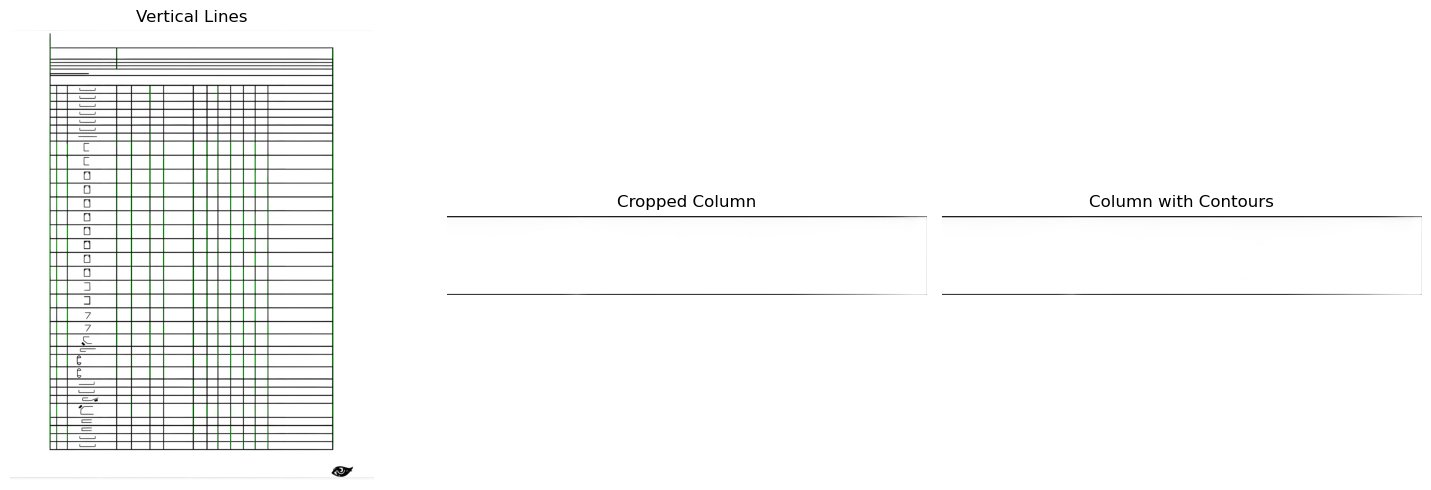

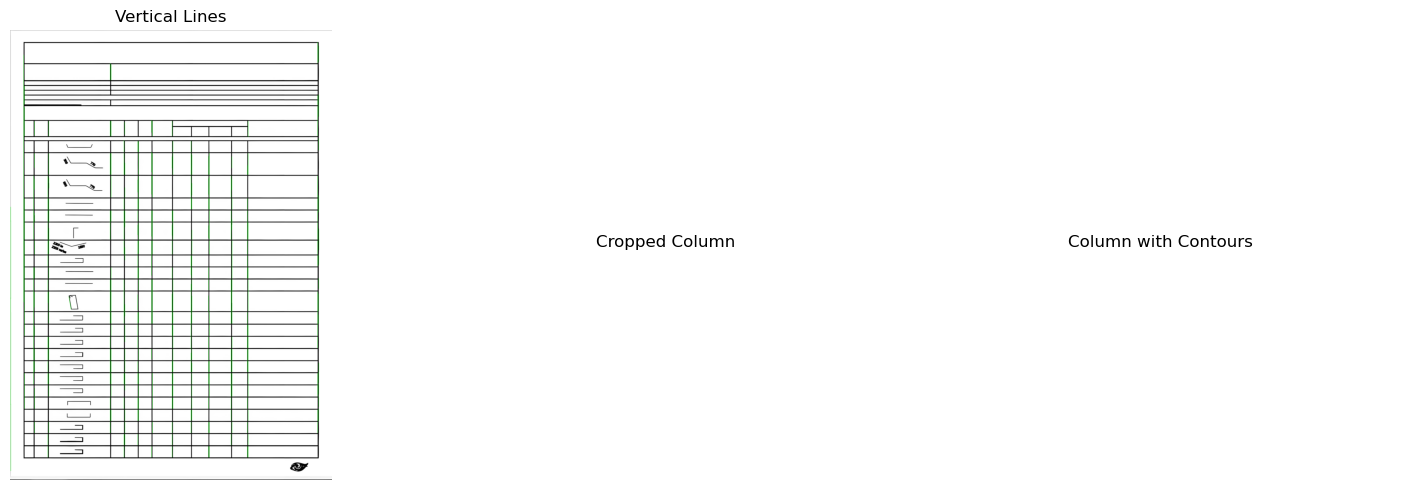

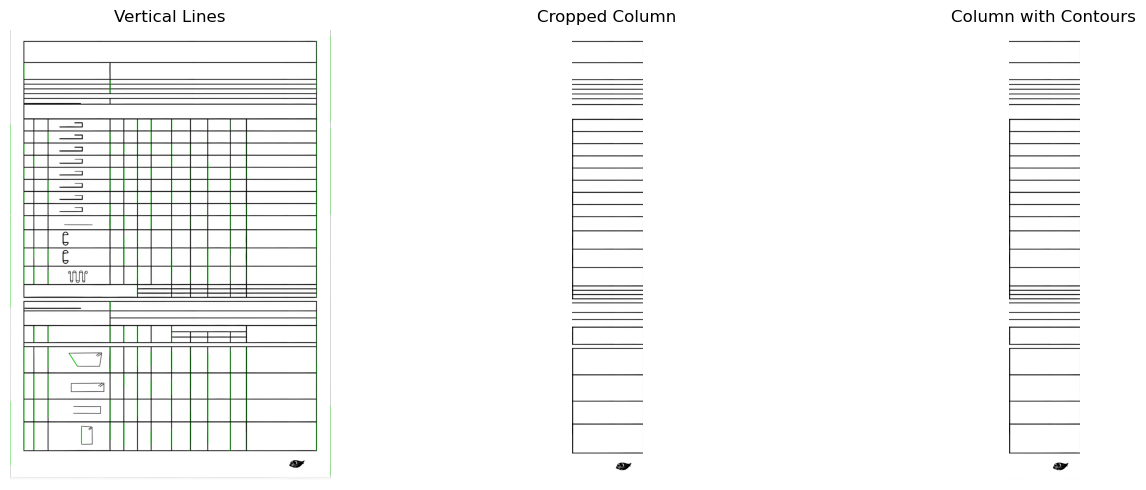

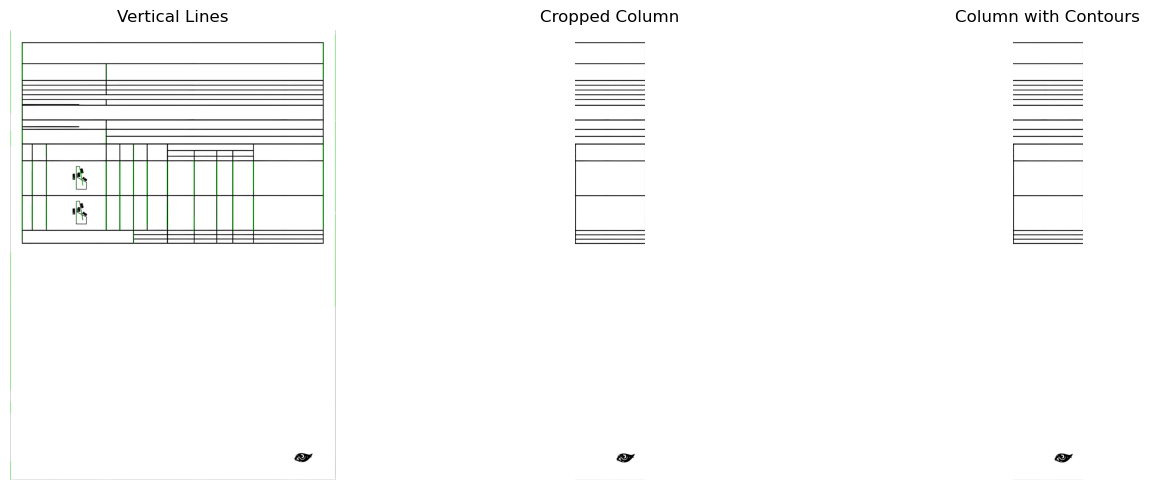

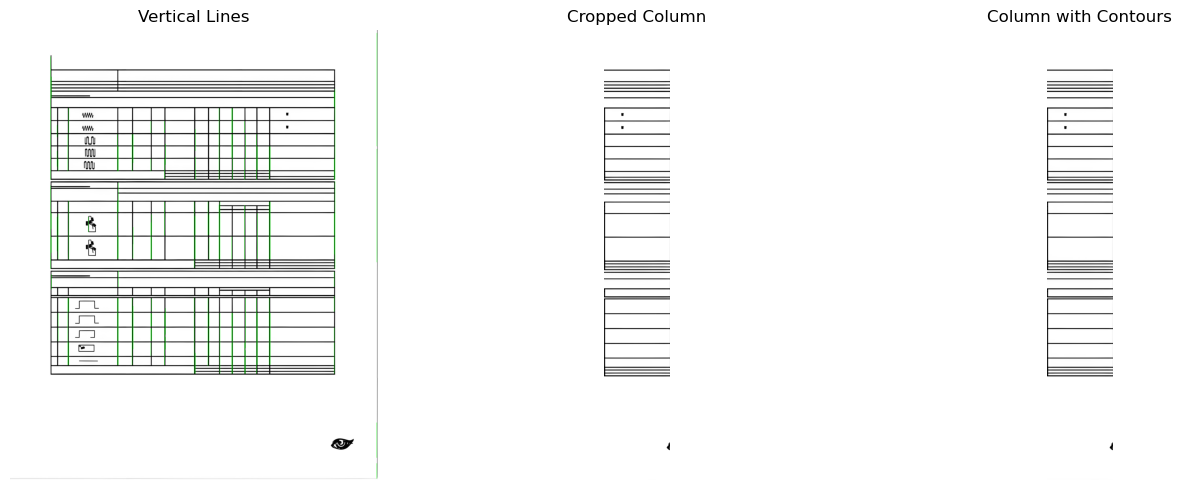

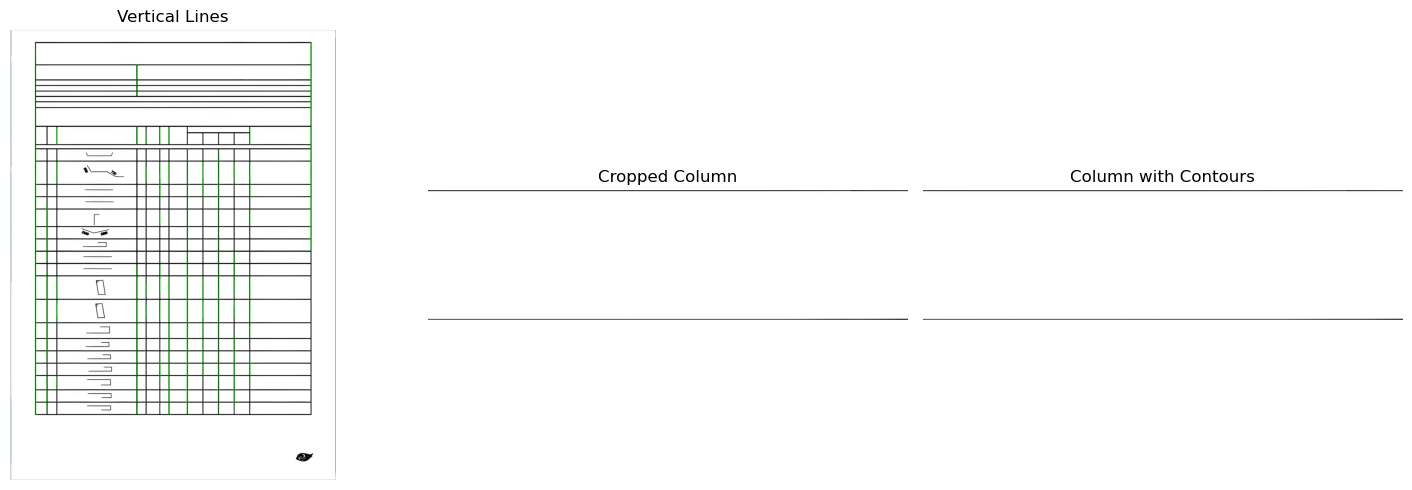

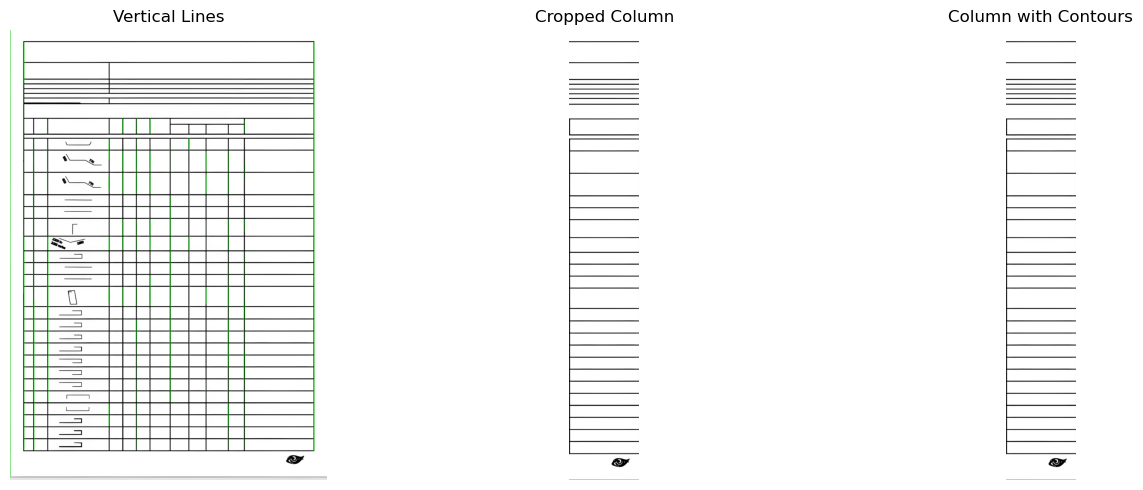